In [1]:
pip install statsmodels numpy pandas

In [2]:
pip install yfinance pandas

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import os

TICKER = 'SPY' # The S&P 500 ETF
START_DATE = '2018-01-01'
END_DATE = '2024-01-01'
OUTPUT_DIR = 'DATA'

# --- Setup ---
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print(f"-> Starting project setup for Single-Index Mean Reversion on {TICKER}")

# --- Data Download ---
try:
    data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
    price_data = data[['Close']].copy()
    price_data.columns = [TICKER] # Rename to ticker symbol

    print(f"-> Data for {TICKER} downloaded successfully. Total rows: {len(price_data)}")

except Exception as e:
    print(f"Error downloading data: {e}")
    price_data = pd.DataFrame() # Create empty dataframe on failure

-> Starting project setup for Single-Index Mean Reversion on SPY


[*********************100%***********************]  1 of 1 completed

-> Data for SPY downloaded successfully. Total rows: 1509


In [4]:
WINDOW_MA = 200 # Mean Reversion window
WINDOW_TREND = 400 # Long-term filter window (to define the overall trend)
WINDOW_Z = 60   # Window for Z-score standard deviation calculation
ENTRY_Z = 1.5   # Enter trade when Z-Score is +/- 1.5
EXIT_Z = 0.5    # Exit trade when Z-Score is near 0.5
STOP_Z = 3.0    # CRITICAL: Stop-Loss threshold

def generate_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates trading signals based on the price deviation from a long-term MA,
    filtered by a super-long-term trend (Trend_MA).
    """

    # 1. Calculate Moving Averages and Deviation ("Spread")
    df['MA'] = df[TICKER].rolling(window=WINDOW_MA).mean()
    df['Trend_MA'] = df[TICKER].rolling(window=WINDOW_TREND).mean() # NEW TREND FILTER
    df['Spread'] = df[TICKER] - df['MA']

    # Use a copy to avoid SettingWithCopyWarning
    df = df.dropna(subset=['MA', 'Spread', 'Trend_MA']).copy()

    # 2. Calculate Z-Score
    df['Spread_Std'] = df['Spread'].rolling(window=WINDOW_Z).std()
    df['Z_Score'] = df['Spread'] / df['Spread_Std']

    # --- 3. Signal Generation with Trend Filter ---
    df['Signal'] = 0

    # Long Position (Buy SPY):
    # Must be BELOW the MA (Z < -ENTRY_Z) AND ABOVE the Trend_MA (Uptrend)
    df.loc[(df['Z_Score'] < -ENTRY_Z) & (df[TICKER] > df['Trend_MA']), 'Signal'] = 1

    # Short Position (Sell/Short SPY):
    # Must be ABOVE the MA (Z > ENTRY_Z) AND BELOW the Trend_MA (Downtrend)
    df.loc[(df['Z_Score'] > ENTRY_Z) & (df[TICKER] < df['Trend_MA']), 'Signal'] = -1

    # Exit Position (Z-Score returns to mean)
    df.loc[np.abs(df['Z_Score']) < EXIT_Z, 'Signal'] = 0

    # --- 4. Position Management & Stop-Loss ---

    # Ffill the signal to maintain position until exit
    df['Position_Held'] = df['Signal'].ffill().fillna(0)

    # Apply the CRITICAL Stop-Loss rule
    df.loc[np.abs(df['Z_Score']) >= STOP_Z, 'Position_Held'] = 0

    df['Signal'] = df['Position_Held']

    print(f"-> Signals generated: MA={WINDOW_MA} days, Trend Filter={WINDOW_TREND} days, Stop-Loss Z={STOP_Z}")
    return df

# --- Main Execution ---
if not price_data.empty:
    strategy_df = generate_signals(price_data)

    OUTPUT_FILE = os.path.join(OUTPUT_DIR, f'strategy_data_{TICKER}.csv')
    strategy_df.to_csv(OUTPUT_FILE)
    print(f"Strategy data saved for backtesting: {OUTPUT_FILE}")

-> Signals generated: MA=200 days, Trend Filter=400 days, Stop-Loss Z=3.0
Strategy data saved for backtesting: DATA/strategy_data_SPY.csv


-> Strategy data loaded successfully. (SPY)
-> Backtest simulation completed.

FINAL SPY MEAN REVERSION PERFORMANCE:
Total Return                  : 1.84%
Annualized Return             : 0.44%
Annualized Volatility         : 3.03%
Sharpe Ratio (Annualized)     : 0.14
Maximum Drawdown              : 2.90%
Total Trades                  : 8.0


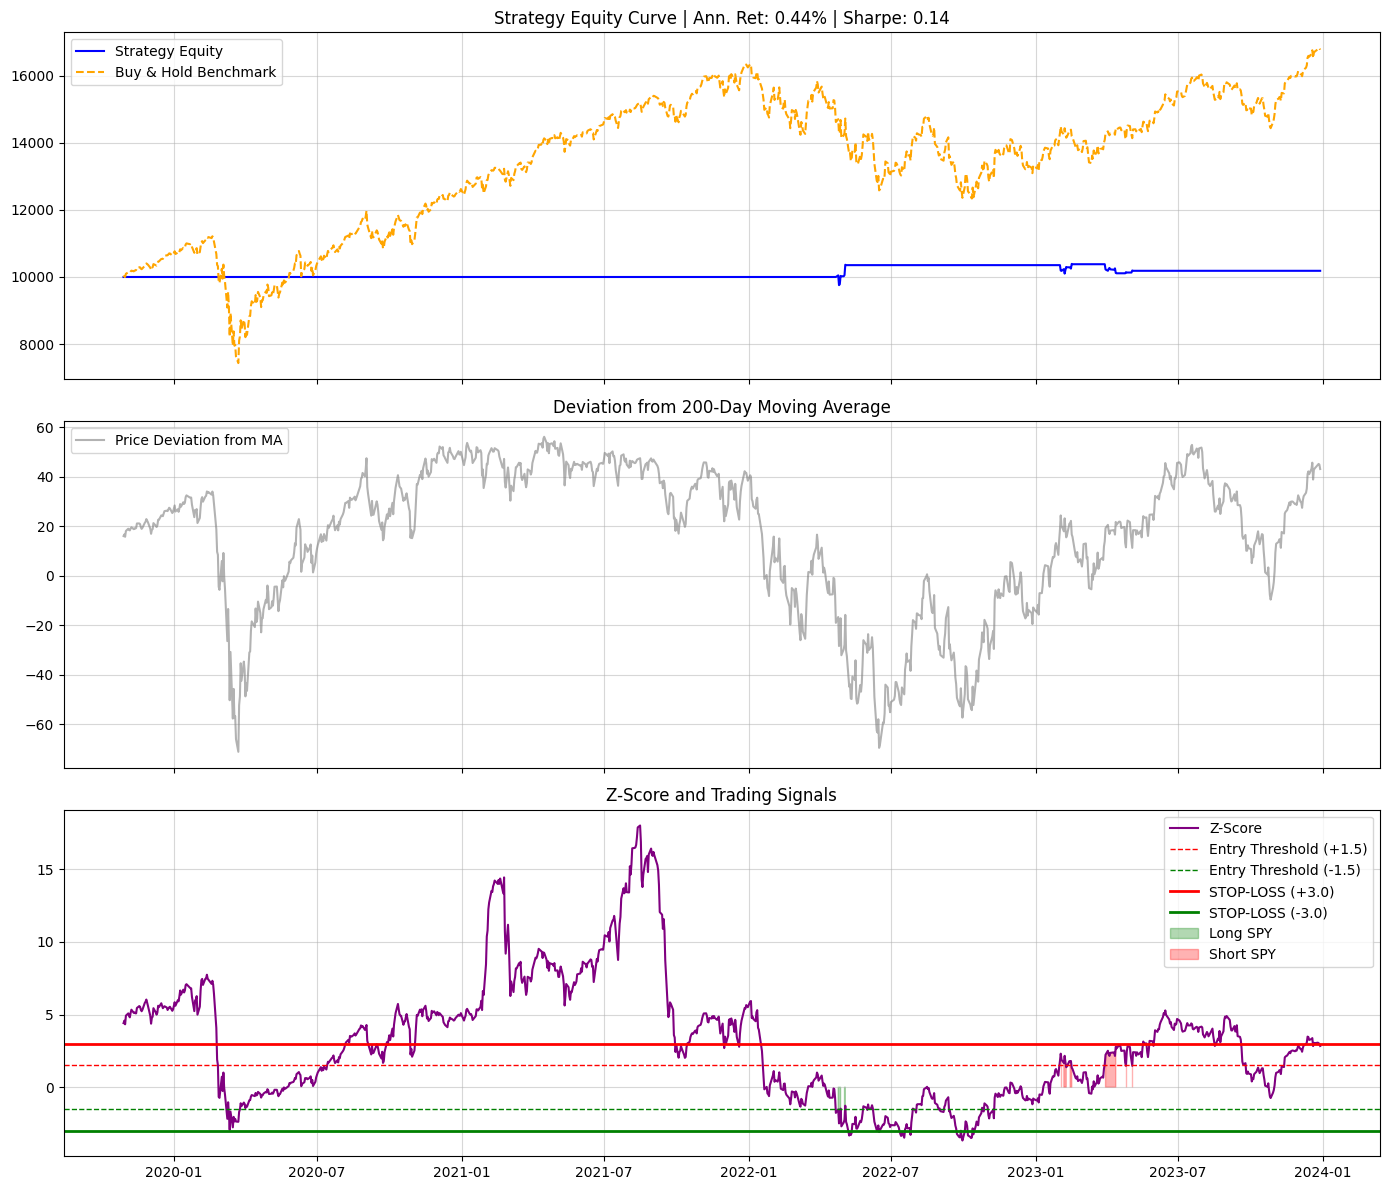

In [5]:
INPUT_STRATEGY_FILE = os.path.join(OUTPUT_DIR, f'strategy_data_{TICKER}.csv')
TRANSACTION_COST = 0.001 # 0.1% per trade
INITIAL_CAPITAL = 10000

def load_strategy_data(file_pattern: str) -> pd.DataFrame:
    """Loads the strategy data file."""
    try:
        data = pd.read_csv(file_pattern, index_col=0, parse_dates=True)
        print(f"-> Strategy data loaded successfully. ({TICKER})")
        return data
    except FileNotFoundError:
        print(f"Error: Strategy data not found at {file_pattern}. Please check the filename.")
        return pd.DataFrame()

def run_backtest(df: pd.DataFrame, initial_capital: float, t_cost: float) -> pd.DataFrame:
    """
    Simulates the trades based on the generated signals and calculates returns.
    """
    df = df.dropna().copy()

    # Asset return is the daily change in SPY price
    df['Asset_Return'] = df[TICKER].pct_change()

    # Position: Use yesterday's signal for today's trade
    df['Position'] = df['Signal'].ffill().shift(1).fillna(0)

    # Daily Strategy Return (Position * Asset Return)
    df['Daily_Return'] = df['Position'] * df['Asset_Return']

    # Account for transaction costs only on days a trade changes position
    df['Trade_Change'] = (df['Position'].diff() != 0).astype(int)
    df['Cost'] = df['Trade_Change'] * t_cost

    # Final Daily Return after cost
    df['Strategy_Return'] = df['Daily_Return'] - df['Cost']

    # Calculate Equity Curve
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()
    df['Equity_Curve'] = initial_capital * df['Cumulative_Return']

    print("-> Backtest simulation completed.")
    return df.dropna()

def calculate_metrics(df: pd.DataFrame) -> dict:
    """Calculates key performance metrics."""
    total_return = (df['Cumulative_Return'].iloc[-1] - 1)
    annual_return = (1 + total_return) ** (252 / len(df)) - 1
    annual_volatility = df['Strategy_Return'].std() * np.sqrt(252)

    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

    df['HighWaterMark'] = df['Equity_Curve'].cummax()
    max_drawdown = (1 - (df['Equity_Curve'] / df['HighWaterMark'])).max()

    return {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{annual_return * 100:.2f}%",
        "Annualized Volatility": f"{annual_volatility * 100:.2f}%",
        "Sharpe Ratio (Annualized)": f"{sharpe_ratio:.2f}",
        "Maximum Drawdown": f"{max_drawdown * 100:.2f}%",
        "Total Trades": df['Trade_Change'].sum() / 2
    }

def plot_results(df: pd.DataFrame, metrics: dict):
    """Generates visualizations, comparing strategy to a simple buy-and-hold benchmark."""

    # Benchmark is a simple buy-and-hold of the SPY index itself
    buy_hold_returns = df[TICKER].pct_change().fillna(0)
    buy_hold_cumulative = (1 + buy_hold_returns).cumprod() * df['Equity_Curve'].iloc[0]

    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Plot 1: Equity Curve with Benchmark
    axes[0].plot(df['Equity_Curve'], label='Strategy Equity', color='blue')
    axes[0].plot(buy_hold_cumulative, label='Buy & Hold Benchmark', color='orange', linestyle='--')

    axes[0].set_title(f'Strategy Equity Curve | Ann. Ret: {metrics["Annualized Return"]} | Sharpe: {metrics["Sharpe Ratio (Annualized)"]}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.5)

    # Plot 2: Dynamic Spread (Deviation from MA)
    axes[1].plot(df['Spread'], label='Price Deviation from MA', color='gray', alpha=0.6)
    axes[1].set_title(f'Deviation from {WINDOW_MA}-Day Moving Average')
    axes[1].legend()
    axes[1].grid(True, alpha=0.5)

    # Plot 3: Z-Score and Trading Signals
    axes[2].plot(df['Z_Score'], label='Z-Score', color='purple')
    axes[2].axhline(ENTRY_Z, color='red', linestyle='--', linewidth=1, label=f'Entry Threshold (+{ENTRY_Z})')
    axes[2].axhline(-ENTRY_Z, color='green', linestyle='--', linewidth=1, label=f'Entry Threshold (-{ENTRY_Z})')
    # Add Stop-Loss line
    axes[2].axhline(STOP_Z, color='red', linestyle='-', linewidth=2, label=f'STOP-LOSS (+{STOP_Z})')
    axes[2].axhline(-STOP_Z, color='green', linestyle='-', linewidth=2, label=f'STOP-LOSS (-{STOP_Z})')

    axes[2].fill_between(df.index, 0, df['Z_Score'], where=df['Position'] == 1, color='green', alpha=0.3, label='Long SPY')
    axes[2].fill_between(df.index, 0, df['Z_Score'], where=df['Position'] == -1, color='red', alpha=0.3, label='Short SPY')
    axes[2].set_title('Z-Score and Trading Signals')
    axes[2].legend()
    axes[2].grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":

    strategy_df = load_strategy_data(INPUT_STRATEGY_FILE)

    if not strategy_df.empty:
        performance_df = run_backtest(strategy_df.copy(), INITIAL_CAPITAL, TRANSACTION_COST)
        metrics = calculate_metrics(performance_df)

        print("\n" + "="*50)
        print(f"FINAL {TICKER} MEAN REVERSION PERFORMANCE:")
        print("="*50)
        for key, value in metrics.items():
            print(f"{key:<30}: {value}")
        print("="*50)

        plot_results(performance_df, metrics)